In [19]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.axes as axt
import glob
import anndata
import bbknn



In [20]:
import decoupler as dc

In [21]:
data_path = '../data/'

In [22]:
adata = sc.read_h5ad(data_path + 'combined.epi.anno.h5ad')

In [23]:
adata.X = np.round(adata.X)
adata.X = np.absolute(adata.X)
adata.layers['counts'] = adata.X


In [24]:
pdata = dc.get_pseudobulk(
    adata,
    sample_col='Sample',
    groups_col='cell_label',
    layer='counts',
    mode='sum',
    min_cells=0,
    min_counts=0)


In [25]:
pdata.layers['counts'] = pdata.X.copy()
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata,max_value=10)
sc.tl.pca(pdata)
dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)


In [26]:
dc.get_metadata_associations(
    pdata,
    obs_keys = ['Health', 'cell_label', 'psbulk_n_cells', 'psbulk_counts'],  
    obsm_key='X_pca',  
    uns_key='pca_anova',  
    inplace=True)


In [27]:
dcs = pdata[pdata.obs['cell_label'] == 'DCS'].copy()

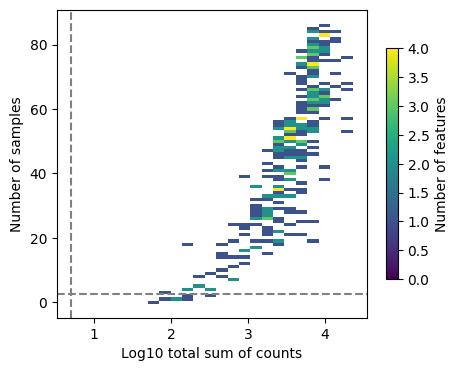

In [28]:
dc.plot_filter_by_expr(dcs, group='Health', min_count=1, min_total_count=5)
genes = dc.filter_by_expr(dcs, group='Health', min_count=1, min_total_count=5)
dcs = dcs[:, genes].copy()
dcs.X = np.round(dcs.X)


In [29]:
dcs.obs['Health_Any'] = dcs.obs['Health']
dcs.obs['Health_Any'] = dcs.obs['Health_Any'].replace('Infl','Inflamed')
dcs.obs['Health_Any'] = dcs.obs['Health_Any'].replace('Inflamed','Inflamed')
dcs.obs['Health_Any'] = dcs.obs['Health_Any'].replace('Non-inflamed','NonInflamed')
dcs.obs['Health_Any'] = dcs.obs['Health_Any'].replace('NonI','NonInflamed')
dcs.obs['Health_Any'] = dcs.obs['Health_Any'].replace('Heal','Healthy')
dcs.obs['Health_Any'] = dcs.obs['Health_Any'].replace('Healthy','Healthy')

from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    adata=dcs,
    design_factors='Health_Any',
    ref_level=['Inflamed', 'NonInflamed'],
    refit_cooks=True,
    inference=inference)
dds.deseq2()
stat_res = DeseqStats(
    dds,
    contrast=["Health_Any", 'Inflamed','NonInflamed'],
    inference=inference)



Using None as control genes, passed at DeseqDataSet initialization


/tmp/ipykernel_17599/1094141947.py:12: DeprecationWarning: ref_level is deprecated and no longer has any effect. It will beremoved in a future release.
  dds = DeseqDataSet(
/tmp/ipykernel_17599/1094141947.py:12: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.04 seconds.

Fitting dispersion trend curve...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.15 seconds.

Fitting LFCs...
... done in 0.09 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 6 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



In [30]:
stat_res.summary()

Log2 fold change & Wald test p-value: Health_Any Inflamed vs NonInflamed
        baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
ABCA5   5.133290       -0.068499  0.410043 -0.167054  0.867328  0.966825
ABCG2   1.484047       -0.272760  0.726892 -0.375241  0.707481  0.926219
ABHD3   5.227822        0.383524  0.280049  1.369490  0.170846  0.806518
ABHD5   3.781664        0.253365  0.390369  0.649040  0.516312  0.907066
ADM    11.260535        0.057958  0.279264  0.207537  0.835590  0.947343
...          ...             ...       ...       ...       ...       ...
USP15   4.998162        0.437192  0.329493  1.326865  0.184553  0.806518
VIM     7.304894       -0.096465  0.602803 -0.160028  0.872859  0.966825
WDR60   5.093118        0.681231  0.415770  1.638480  0.101322  0.806518
WFDC2  11.620562       -0.133344  0.293792 -0.453871  0.649922  0.911805
ZG16   13.801951       -0.182787  0.283372 -0.645040  0.518901  0.907066

[284 rows x 6 columns]


Running Wald tests...
... done in 0.05 seconds.



In [31]:
results_df = stat_res.results_df

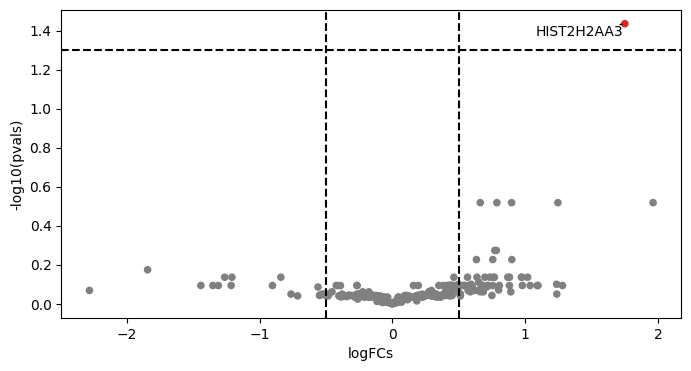

In [32]:
dc.plot_volcano_df(
    results_df,
    x='log2FoldChange',
    y='padj',
    top=20,
    figsize=(8, 4))


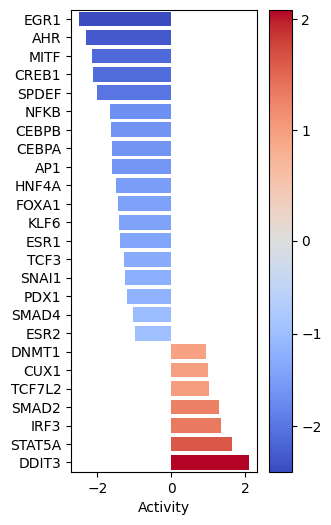

In [33]:
mat = results_df[['stat']].T.rename(index={'stat': 'DCS'})
net = dc.get_collectri(organism='human', split_complexes=False)
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=net)
dc.plot_barplot(
    acts=tf_acts,
    contrast='DCS',
    top=25,
    vertical=True,
    figsize=(3, 6))


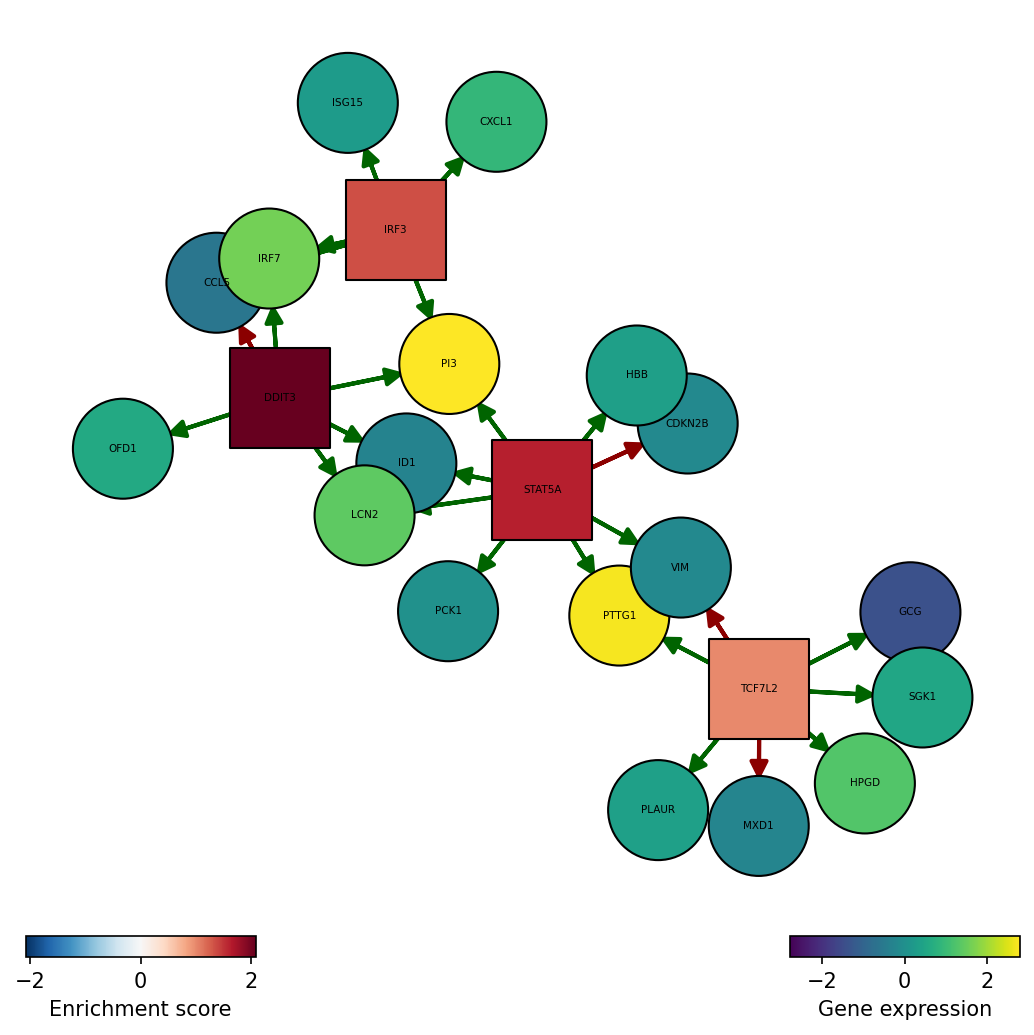

In [34]:
dc.plot_network(
    net=net,
    obs=mat,
    act=tf_acts,
    n_sources=['DDIT3', 'STAT5A', 'IRF3', 'TCF7L2'],
    n_targets=25,
    node_size=100,
    figsize=(7, 7),
    c_pos_w='darkgreen',
    c_neg_w='darkred',
    vcenter=True)


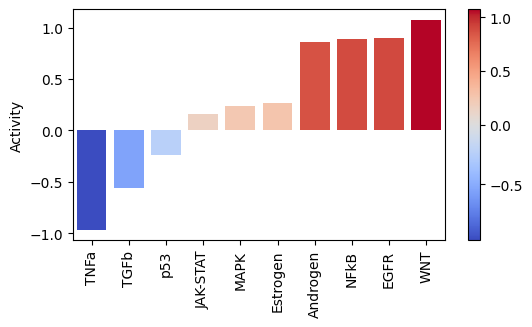

In [35]:
progeny = dc.get_progeny(top=500)
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny)
dc.plot_barplot(
    acts=pathway_acts,
    contrast='DCS',
    top=25,
    vertical=False,
   figsize=(6, 3))


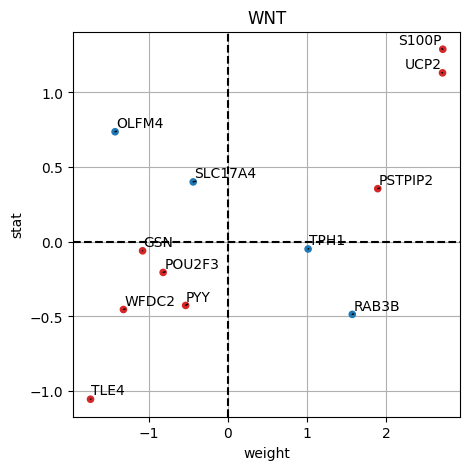

In [36]:
dc.plot_targets(
    data=results_df,
    stat='stat',
    source_name='WNT',
    net=progeny,
    top=15)
